In [1]:
import csv
import os
import spacy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

csv_filename = 'fie_2025_papers.csv'


In [2]:
# Load the CSV file
papers = []

try:
    with open(csv_filename, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            papers.append(row)
except FileNotFoundError:
    print(f"'{csv_filename}' was not found.")
except Exception as e:
    print(f"An error occurred while reading '{csv_filename}': {e}")

# Display the first few rows of the data
if papers:
    print(f"Loaded {len(papers)} papers from '{csv_filename}'.")
    for paper in papers[:5]:  # Display the first 5 papers
        print(paper)

Loaded 587 papers from 'fie_2025_papers.csv'.
{'Day': 'Monday, Nov 3', 'SessionCode': 'M1-RBA', 'SessionTitle': 'Computing Undergraduate 1: Introductory Levels', 'Room': 'Riverbed A', 'PaperTime': '8:00', 'PaperTitle': 'Scaffolding the Problem-Solving Process for Introductory Computing Students', 'Authors': 'Ashish Deepak Dandekar (National University of Singapore, Singapore); Nitya Lakshmanan (NUS, Singapore); Daren Ler, Adi Yoga Sidi Prabawa and Sanka Rasnayaka (National University of Singapore, Singapore)'}
{'Day': 'Monday, Nov 3', 'SessionCode': 'M1-RBA', 'SessionTitle': 'Computing Undergraduate 1: Introductory Levels', 'Room': 'Riverbed A', 'PaperTime': '8:15', 'PaperTitle': 'WIP: Exploratory Analysis of Code Quality Issues in CS1', 'Authors': 'Isabela Vieira Rodrigues and Igor dos Santos Montagner (Insper, Brazil)'}
{'Day': 'Monday, Nov 3', 'SessionCode': 'M1-RBA', 'SessionTitle': 'Computing Undergraduate 1: Introductory Levels', 'Room': 'Riverbed A', 'PaperTime': '8:30', 'PaperT

In [6]:
# Load into pandas DataFrame for analysis
df = pd.DataFrame(papers)

# Display basic information about the DataFrame
df.info()

# Unique values in 'Session' column
if 'SessionCode' in df.columns:
    unique_sessions = df['SessionCode'].unique()
    print(f"Unique sessions: {len(unique_sessions)}")
    print(unique_sessions)

if 'Room' in df.columns:
    unique_rooms = df['Room'].unique()
    print(f"Unique rooms: {len(unique_rooms)}")
    print(unique_rooms)

# Count of papers per room
if 'Room' in df.columns:
    room_counts = df['Room'].value_counts()
    print("Papers per room:")
    print(room_counts)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Day           587 non-null    object
 1   SessionCode   587 non-null    object
 2   SessionTitle  587 non-null    object
 3   Room          587 non-null    object
 4   PaperTime     587 non-null    object
 5   PaperTitle    587 non-null    object
 6   Authors       587 non-null    object
dtypes: object(7)
memory usage: 32.2+ KB
Unique sessions: 102
['M1-RBA' 'M1-RBC' 'M1-RBD' 'M1-WPA' 'M1-WPB' 'M1-WPC' 'M1-WPE' 'M2-RBA'
 'M2-RBC' 'M2-RBD' 'M2-WPA' 'M2-WPB' 'M2-WPC' 'M2-WPD' 'M2-WPE' 'M3-RBA'
 'M3-RBC' 'M3-RBD' 'M3-WPA' 'M3-WPB' 'M3-WPC' 'M3-WPD' 'M3-WPE' 'M4-RBA'
 'M4-RBC' 'M4-RBD' 'M4-WPA' 'M4-WPB' 'M4-WPC' 'M4-WPE' 'M5-RBA' 'M5-RBC'
 'M5-RBD' 'M5-WPB' 'M5-WPC' 'M5-WPD' 'M5-WPE' 'T1-RBA' 'T1-RBC' 'T1-RBD'
 'T1-WPA' 'T1-WPB' 'T1-WPC' 'T1-WPD' 'T2-RBA' 'T2-RBC' 'T2-RBD' 'T2-WPA'
 'T2-WPB' 'T2-WPC'

In [17]:
# Some filtering on titles
df_cleaned = df.copy()

if 'PaperTitle' in df.columns:
    # Replace "GenAI" with "Generative AI" for consistency
    df_cleaned['PaperTitle'] = df_cleaned['PaperTitle'].str.replace(r'\bGen.?AI\b', "Generative AI", regex=True)

    # Common acronyms
    acronyms = {
        "AI": "Artificial Intelligence",
        "ML": "Machine Learning",
        "LLM": "Large Language Model",
        "NLP": "Natural Language Processing",
        "RL": "Reinforcement Learning",
        "VR": "Virtual Reality",
        "AR": "Augmented Reality",
        "XR": "Mixed Reality",
        "IoT": "Internet of Things",
    }

    # Replace acronyms in the PaperTitle
    for abbr, full in acronyms.items():
        df_cleaned['PaperTitle'] = df_cleaned['PaperTitle'].str.replace(rf'\b{abbr}\b', full, regex=True)

    # Replace X-based learning with "X based learning"
    df_cleaned['PaperTitle'] = df_cleaned['PaperTitle'].str.replace(r'(\b\w+)-[Bb]ased [Ll]earning', r'\1 based learning', regex=True)

    # Remove other hyphens
    df_cleaned['PaperTitle'] = df_cleaned['PaperTitle'].str.replace(r'-', ' ', regex=True)



In [8]:
# Count WIP papers

if 'PaperTitle' in df_cleaned.columns:
    wip_count = df_cleaned['PaperTitle'].str.startswith('WIP').sum()

    # Create two separate DataFrames for WIP and non-WIP papers
    wip_papers = df_cleaned[df_cleaned['PaperTitle'].str.startswith('WIP')]
    non_wip_papers = df_cleaned[~df_cleaned['PaperTitle'].str.startswith('WIP')]

    # Remove 'WIP' prefix from titles in WIP papers DataFrame
    # Will be either 'WIP - Title' or 'WIP: Title' or 'WIP Title'
    wip_papers = wip_papers.copy()
    wip_papers['PaperTitle'] = wip_papers['PaperTitle'].str.replace(r'^WIP\s*[-:]\s*', '', regex=True)

    # Verify counts
    print(f"WIP papers count: {len(wip_papers)}")
    print(f"Non-WIP papers count: {len(non_wip_papers)}")
    print(f"Total papers count: {len(df_cleaned)}")
    assert len(wip_papers) + len(non_wip_papers) == len(df_cleaned), "Counts do not add up!"


WIP papers count: 222
Non-WIP papers count: 365
Total papers count: 587


In [18]:
def title_analysis(df):
    # Title words count analysis
    if 'PaperTitle' in df.columns:
        titles = df['PaperTitle'].tolist()
        from sklearn.feature_extraction.text import CountVectorizer
        vectorizer = CountVectorizer(stop_words='english')
        X = vectorizer.fit_transform(titles)
        word_counts = np.asarray(X.sum(axis=0)).flatten()
        words = vectorizer.get_feature_names_out()
        word_count_df = pd.DataFrame({'word': words, 'count': word_counts})

        top_words = word_count_df.sort_values(by='count', ascending=False).head(20)
        print("Top words in paper titles:")
        print(top_words)

        # Visualize the top words
        plt.figure(figsize=(10, 6))
        plt.barh(top_words['word'], top_words['count'], color='skyblue')
        plt.xlabel('Count')
        plt.title('Top Words in Paper Titles')
        plt.gca().invert_yaxis()
        plt.show()

        return word_count_df



WIP Papers Title Analysis:
Top words in paper titles:
              word  count
271    engineering     81
461       learning     47
736       students     38
238      education     36
421   intelligence     34
56      artificial     34
735        student     27
794  undergraduate     22
167         course     21
146       computer     17
76           based     16
657       research     15
803          using     14
201         design     14
726           stem     13
738          study     13
208    development     13
275      enhancing     13
268     engagement     12
169        courses     12


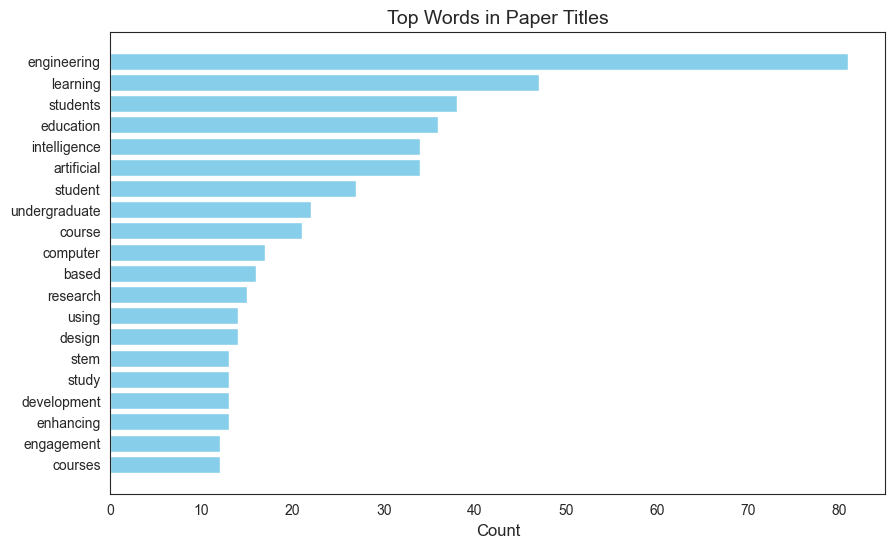


Non-WIP Papers Title Analysis:
Top words in paper titles:
               word  count
368     engineering    100
633        learning     79
1049       students     73
335       education     58
575    intelligence     53
63       artificial     53
96            based     47
1052          study     40
1048        student     40
205        computer     39
1150          using     32
621           large     29
974         science     29
620        language     28
239          course     25
287     development     25
1136  undergraduate     25
373       enhancing     25
869     programming     23
57         approach     23


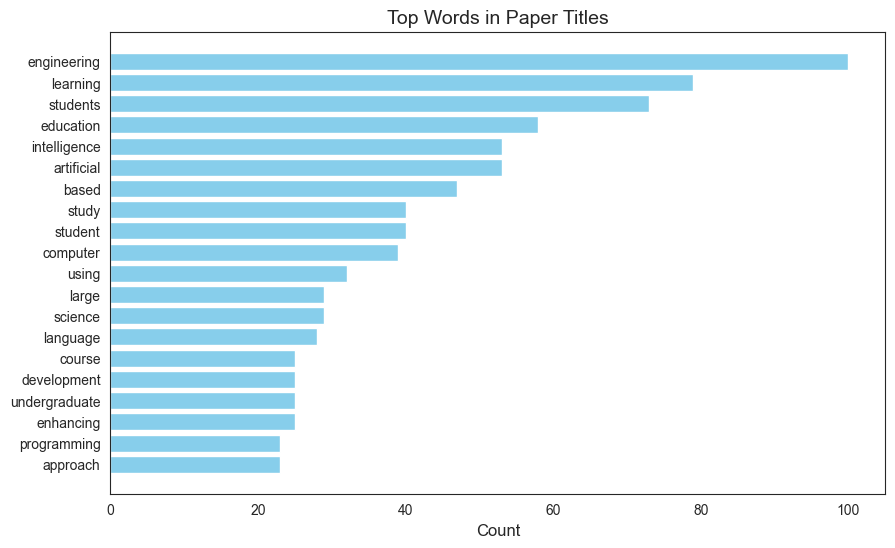

In [19]:
print("WIP Papers Title Analysis:")
wip_word_counts = title_analysis(wip_papers)
print("\nNon-WIP Papers Title Analysis:")
non_wip_word_counts = title_analysis(non_wip_papers)

In [10]:
# Distance between WIP and non-WIP word distributions

# Merge the two word count DataFrames to ensure they have the same words
merged_counts = pd.merge(wip_word_counts, non_wip_word_counts, on='word', suffixes=('_wip', '_non_wip'), how='outer').fillna(0)

# Convert counts to probability distributions
wip_probs = merged_counts['count_wip'] / merged_counts['count_wip'].sum()
non_wip_probs = merged_counts['count_non_wip'] / merged_counts['count_non_wip'].sum()

# Rank correlation
from scipy.stats import spearmanr
correlation, p_value = spearmanr(wip_probs, non_wip_probs)
print(f"Spearman rank correlation between WIP and non-WIP word distributions: {correlation:.4f} (p-value: {p_value:.4e})")

Spearman rank correlation between WIP and non-WIP word distributions: 0.0498 (p-value: 4.7210e-02)


In [21]:
# Top bigrams (common two-word phrases)
from sklearn.feature_extraction.text import CountVectorizer
def top_terms_count(corpus, n=20, ngram=(1,1), min_df=1):
    vectorizer = CountVectorizer(stop_words='english', ngram_range=ngram, min_df=min_df)
    X = vectorizer.fit_transform(corpus)
    term_counts = np.asarray(X.sum(axis=0)).flatten()
    terms = vectorizer.get_feature_names_out()
    term_count_df = pd.DataFrame({'term': terms, 'count': term_counts})
    top_terms = term_count_df.sort_values(by='count', ascending=False).head(n)
    return top_terms

def plot_top_terms(term_count_df, title="Top Terms", rotation=0):
    plt.figure(figsize=(10, 6))
    plt.barh(term_count_df['term'], term_count_df['count'], color='lightgreen')
    plt.xlabel('Count')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.xticks(rotation=rotation)
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Ensure x-axis ticks are integers
    plt.show()



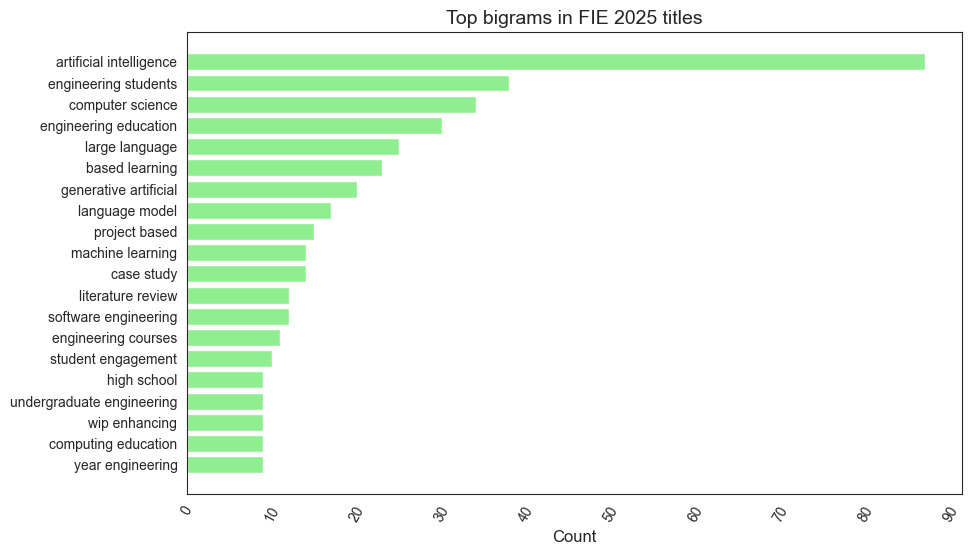

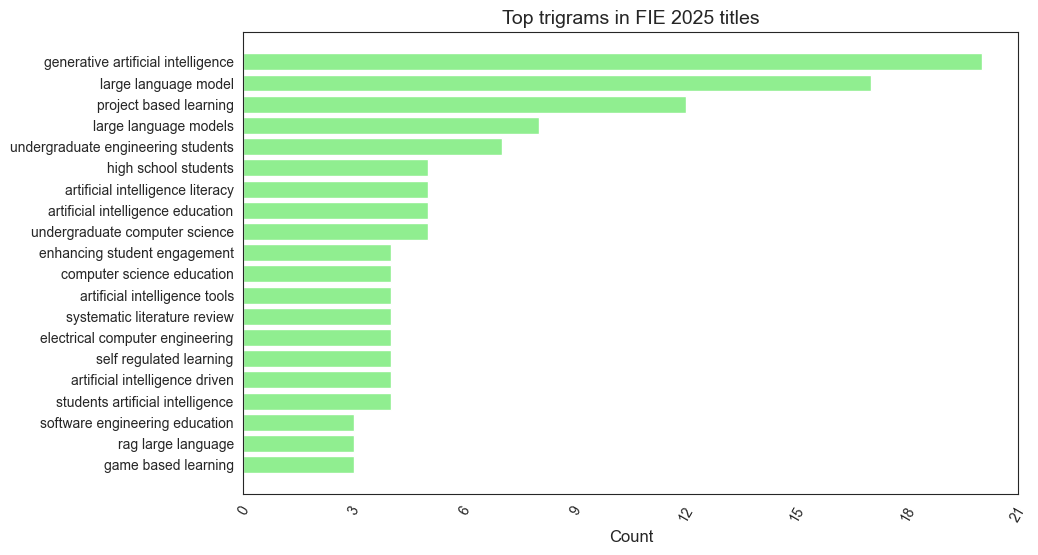

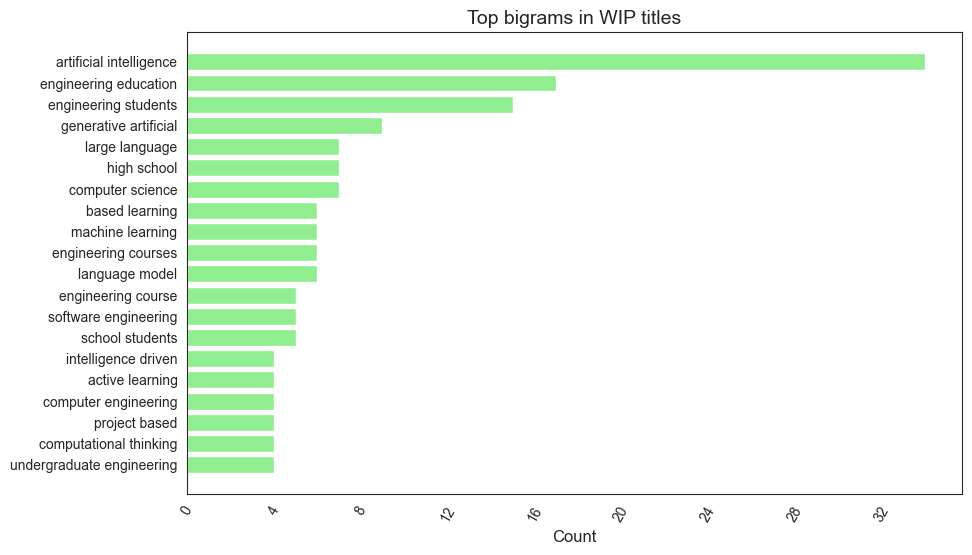

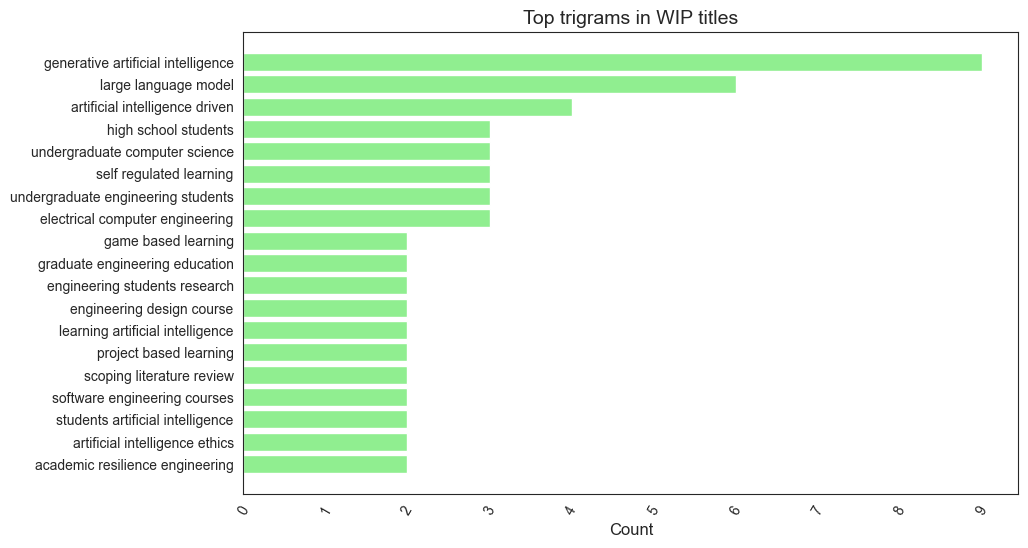

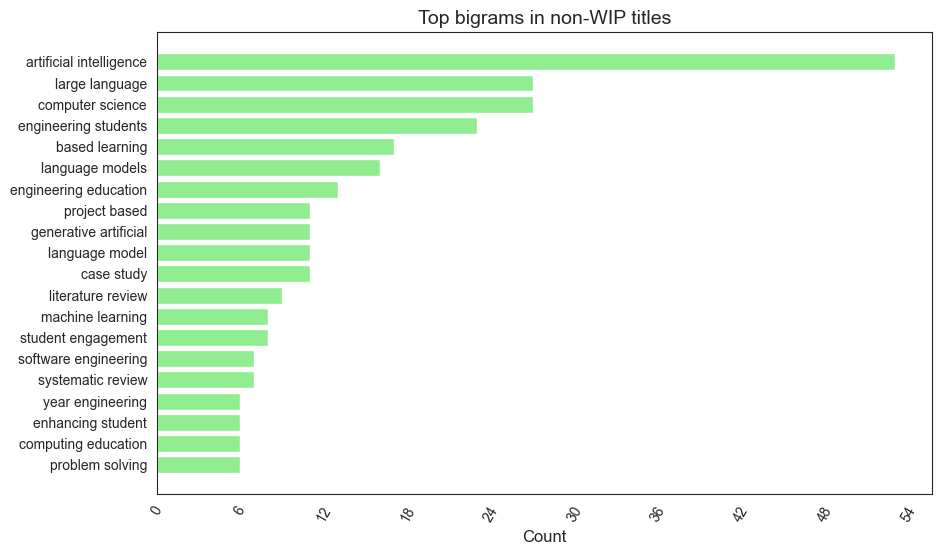

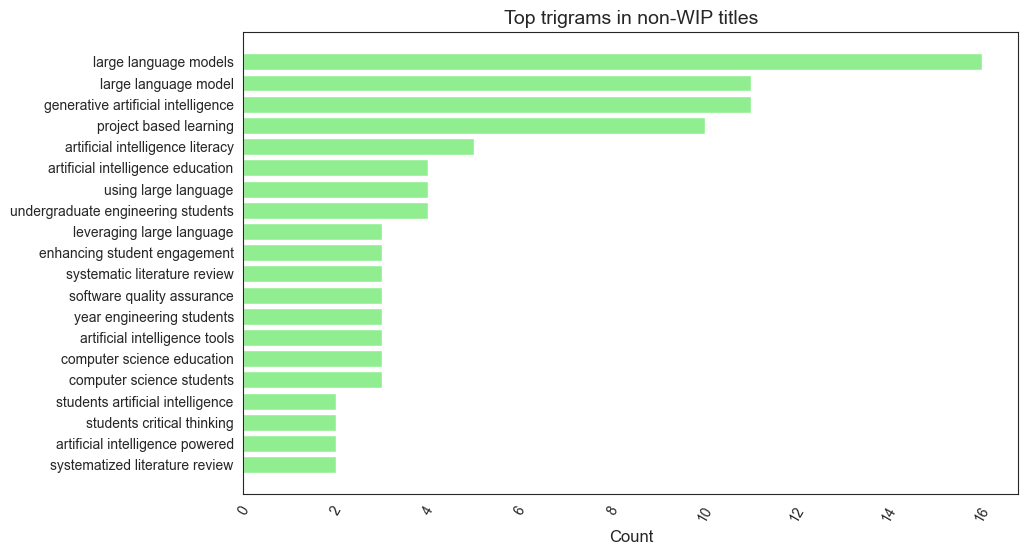

In [60]:

top_bi = top_terms_count(df_cleaned['PaperTitle'].to_list(), n=20, ngram=(2,2), min_df=2)
plot_top_terms(top_bi, title="Top bigrams in FIE 2025 titles", rotation=60)

top_tri = top_terms_count(df_cleaned['PaperTitle'].to_list(), n=20, ngram=(3,3), min_df=2)
plot_top_terms(top_tri, title="Top trigrams in FIE 2025 titles", rotation=60)


top_bi = top_terms_count(wip_papers['PaperTitle'].to_list(), n=20, ngram=(2,2), min_df=2)
plot_top_terms(top_bi, title="Top bigrams in WIP titles", rotation=60)

top_tri = top_terms_count(wip_papers['PaperTitle'].to_list(), n=20, ngram=(3,3), min_df=2)
plot_top_terms(top_tri, title="Top trigrams in WIP titles", rotation=60)


top_bi = top_terms_count(non_wip_papers['PaperTitle'].to_list(), n=20, ngram=(2,2), min_df=2)
plot_top_terms(top_bi, title="Top bigrams in non-WIP titles", rotation=60)

top_tri = top_terms_count(non_wip_papers['PaperTitle'].to_list(), n=20, ngram=(3,3), min_df=2)
plot_top_terms(top_tri, title="Top trigrams in non-WIP titles", rotation=60)


Titles containing 'based learning': 23
PaperTitle
Project    12
Game        3
Problem     3
Inquiry     1
Video       1
Team        1
Quiz        1
Name: count, dtype: int64


/var/folders/1b/6s48_bzn35x99s0bp7fxmgt40000gn/T/ipykernel_71100/90884032.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  based_learning_titles['PaperTitle'] = based_learning_titles['PaperTitle'].str.extract(r'(\b\w+)\s+based learning', expand=False)


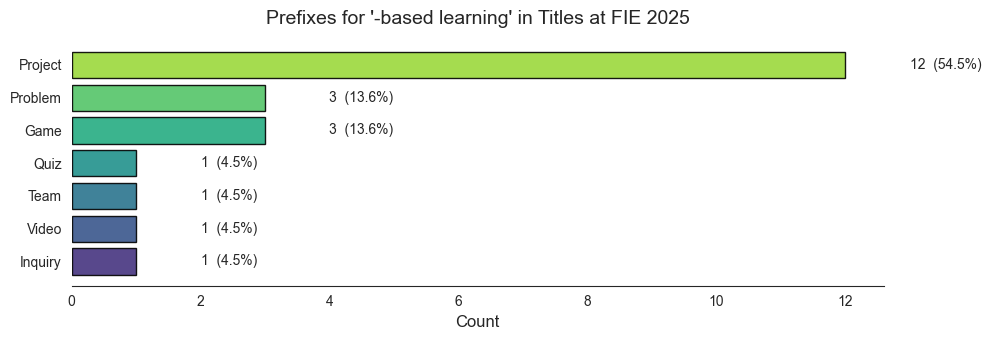

In [13]:
import seaborn as sns

# Find titles containing "based learning" and extract word before
based_learning_titles = df_cleaned[df_cleaned['PaperTitle'].str.contains(r'\bbased learning\b', regex=True, case=False)]
print(f"Titles containing 'based learning': {len(based_learning_titles)}")
based_learning_titles['PaperTitle'] = based_learning_titles['PaperTitle'].str.extract(r'(\b\w+)\s+based learning', expand=False)
print(based_learning_titles['PaperTitle'].value_counts())

# Enhanced / prettier plot for based-learning prefixes 
based_learning_counts = based_learning_titles['PaperTitle'].value_counts()
total = based_learning_counts.sum()

if total == 0:
    print("No '-based learning' prefixes found to plot.")
else:
    sns.set_style("white")  # no grid lines
    plt.rcParams.update({
        "figure.facecolor": "white",
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10
    })

    # sort large->small so largest sits at bottom (inverted y-axis)
    counts = based_learning_counts.sort_values(ascending=True)
    cmap = plt.get_cmap("viridis")
    colors = cmap(np.linspace(0.15, 0.85, len(counts)))

    fig, ax = plt.subplots(figsize=(10, max(3, 0.5 * len(counts))))
    bars = ax.barh(counts.index, counts.values, color=colors, edgecolor='k', alpha=0.9)

    # remove grid lines
    ax.grid(False)

    # annotations: count and percent
    for bar in bars:
        w = bar.get_width()
        pct = w / total
        ax.text(w + max(1, total * 0.01), bar.get_y() + bar.get_height() / 2,
                f"{int(w)}  ({pct:.1%})",
                va='center', fontsize=10)

    ax.set_xlabel("Count")
    ax.set_title("Prefixes for '-based learning' in Titles at FIE 2025", pad=12)
    # do NOT invert y-axis here (we sorted descending so largest will be at the bottom)
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    sns.despine(left=True, bottom=False)
    plt.tight_layout()
    plt.show()


In [ ]:
!uv run spacy -- download en_core_web_trf

In [23]:
# load pipeline
nlp = spacy.load("en_core_web_trf")

def preprocess_text(text):
    doc = nlp(text)
    # lemmatize and remove stop words
    return " ".join([token.lemma_ for token in doc if not token.is_stop])

def spacy_lemma_tokenizer(text):
    doc = nlp(text)
    return [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]

def top_terms_count_normalized(corpus, n=20, ngram=(1,1), min_df=1, tokenizer=spacy_lemma_tokenizer):
    """
    Count n-grams using a spaCy-based lemmatizer tokenizer so plurals/variants collapse.
    tokenizer must return a list of tokens (lemmas).
    """
    # CountVectorizer will not re-lowercase (we already produce lowercase lemmas)
    vec = CountVectorizer(tokenizer=tokenizer, lowercase=False, ngram_range=ngram, min_df=min_df)
    X = vec.fit_transform(corpus)
    term_counts = np.asarray(X.sum(axis=0)).flatten()
    terms = vec.get_feature_names_out()
    term_count_df = pd.DataFrame({'term': terms, 'count': term_counts})
    return term_count_df.sort_values(by='count', ascending=False).head(n)


In [24]:
example = nlp("Large language models are changing AI research.")

for token in example:
    print(f"{token.text:15} {token.lemma_:15} {token.pos_:10} {token.is_stop}")

Large           large           ADJ        False
language        language        NOUN       False
models          model           NOUN       False
are             be              AUX        True
changing        change          VERB       False
AI              ai              NOUN       False
research        research        NOUN       False
.               .               PUNCT      False


/Users/gordon/Documents/fie2025data/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


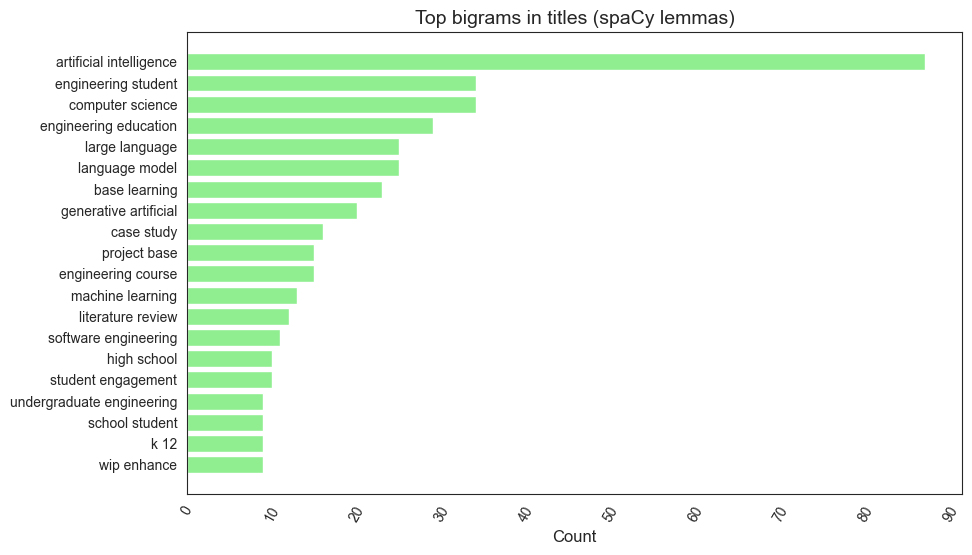

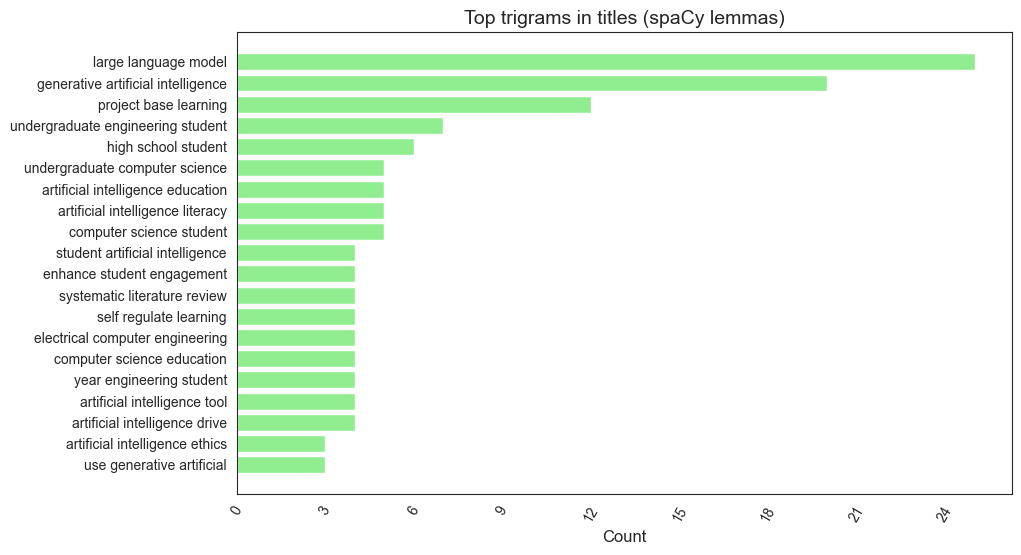

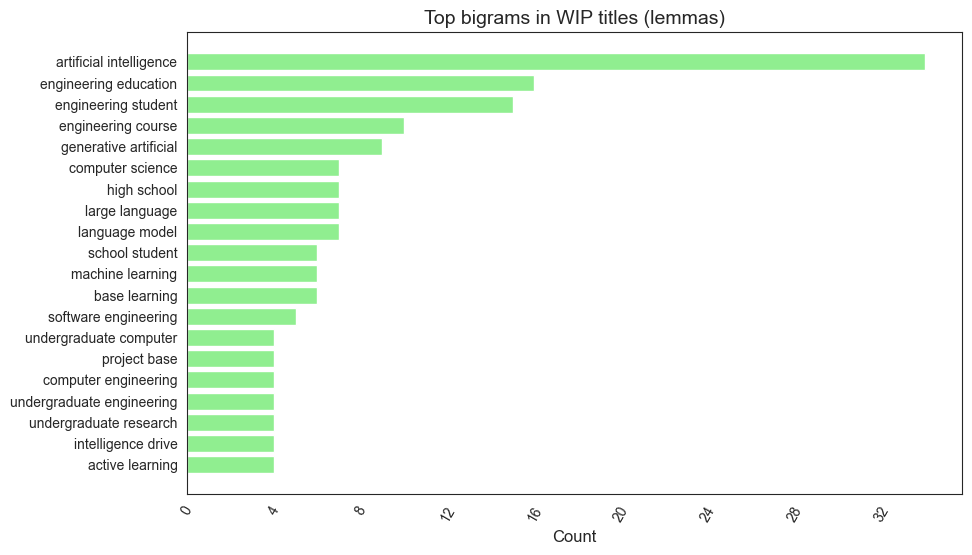

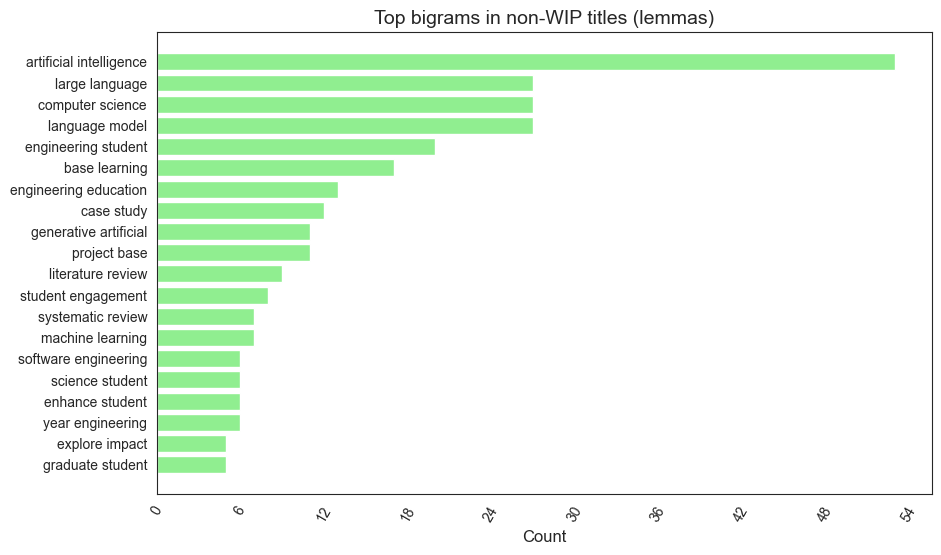

In [ ]:
top_bi = top_terms_count_normalized(df_cleaned['PaperTitle'].fillna('').to_list(), n=20, ngram=(2,2), min_df=2)
plot_top_terms(top_bi, title="Top bigrams in FIE 2025 titles (spaCy lemmas)", rotation=60)

top_tri = top_terms_count_normalized(df_cleaned['PaperTitle'].fillna('').to_list(), n=20, ngram=(3,3), min_df=2)
plot_top_terms(top_tri, title="Top trigrams in FIE 2025 titles (spaCy lemmas)", rotation=60)

# WIP / non-WIP examples
top_bi_wip = top_terms_count_normalized(wip_papers['PaperTitle'].fillna('').to_list(), n=20, ngram=(2,2), min_df=2)
plot_top_terms(top_bi_wip, title="Top bigrams in WIP titles (lemmas)", rotation=60)

top_bi_non = top_terms_count_normalized(non_wip_papers['PaperTitle'].fillna('').to_list(), n=20, ngram=(2,2), min_df=2)
plot_top_terms(top_bi_non, title="Top bigrams in non-WIP titles (lemmas)", rotation=60)


In [29]:
# Clustering titles into themes (TF-IDF + KMeans)
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

title_col = 'PaperTitle'

titles = df_cleaned[title_col].fillna("").astype(str).str.strip()

vec = TfidfVectorizer(stop_words='english', tokenizer=spacy_lemma_tokenizer, ngram_range=(1,2), min_df=2, max_df=0.8)
X = vec.fit_transform(titles)
terms = np.array(vec.get_feature_names_out())



/Users/gordon/Documents/fie2025data/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


KeyboardInterrupt: 

In [55]:
k = 3  # adjust after inspecting results
km = KMeans(n_clusters=k, random_state=0, n_init=10)
labels = km.fit_predict(X)
df["Cluster"] = labels

def top_terms_for_cluster(km, terms, topn=10):
    order = np.argsort(km.cluster_centers_, axis=1)[:, ::-1][:, :topn]
    return [[terms[i] for i in row] for row in order]

In [56]:
cluster_terms = top_terms_for_cluster(km, terms, topn=8)

print("Cluster top terms:")
for i, tlist in enumerate(cluster_terms):
    print(f"  Cluster {i}: " + ", ".join(tlist))

# Show a few example titles per cluster
for i in range(k):
    print(f"\nCluster {i} (size {len(df[df['Cluster'] == i])}) examples:")
    print(df.loc[df["Cluster"] == i, title_col].head(5).to_string(index=False))

Cluster top terms:
  Cluster 0: artificial intelligence, intelligence, artificial, generative artificial, generative, wip, education, engineering
  Cluster 1: wip, engineering, student, learning, course, education, study, computer
  Cluster 2: language model, large language, language, large, model, automate, rag large, base

Cluster 0 (size 81) examples:
STEM Faculty Perspectives: Assessment Design in...
Designing CS Assignments to Foster Cogitation i...
WIP - Developing a Rubric for GenAI Information...
Classification of Kinematics Problems Using Art...
An AI-Enhanced Systematic Review of Barriers to...

Cluster 1 (size 483) examples:
Scaffolding the Problem-Solving Process for Int...
WIP: Exploratory Analysis of Code Quality Issue...
      ILDBug: a New Approach to Teaching Debugging
Microcontroller Hands-on Lesson Plan and Analys...
Exploring Traces from Algorithm Simulation: Stu...

Cluster 2 (size 23) examples:
Optimizing Diary Studies Learning Outcomes With...
Enhancing Large Lan

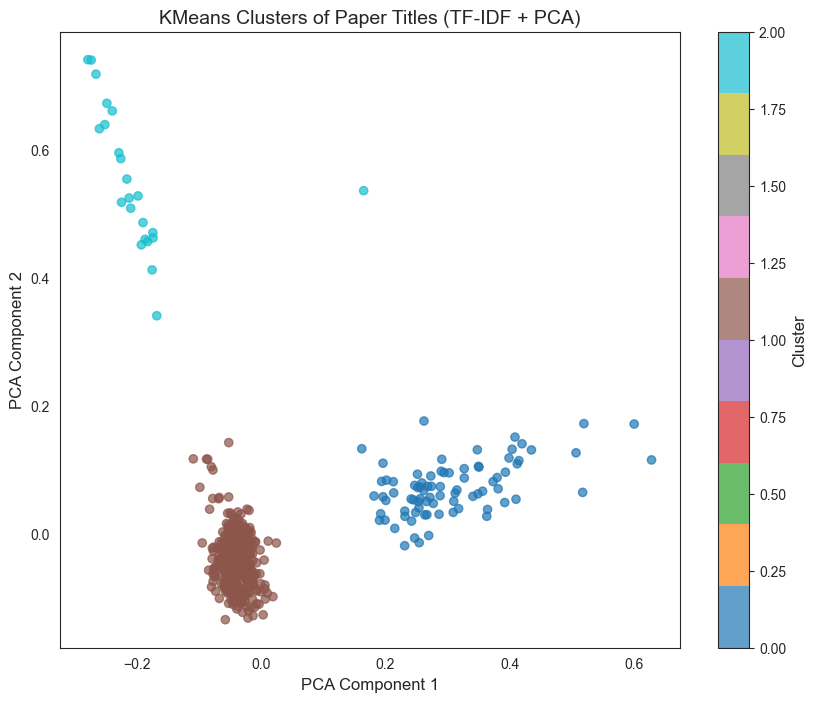

In [57]:
# Use PCA to reduce to 2D for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=0)
X_reduced = pca.fit_transform(X.toarray())

# Plot clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df['Cluster'], cmap='tab10', alpha=0.7)
plt.title("KMeans Clusters of Paper Titles (TF-IDF + PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label='Cluster')
plt.show()

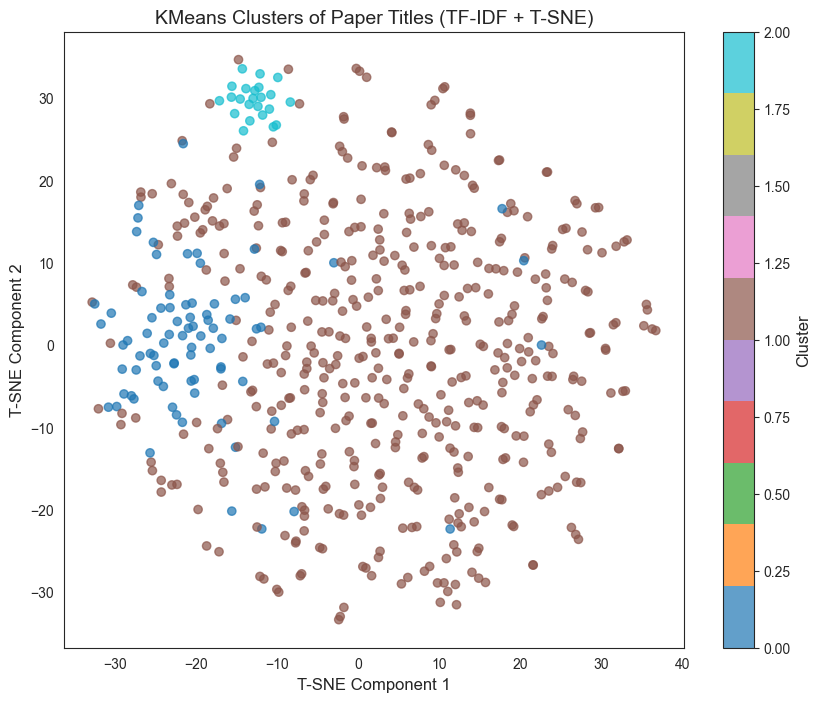

In [58]:
# Try T-SNE for visualization
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0, perplexity=30)
X_tsne = tsne.fit_transform(X.toarray())

# Plot T-SNE clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['Cluster'], cmap='tab10', alpha=0.7)
plt.title("KMeans Clusters of Paper Titles (TF-IDF + T-SNE)")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.colorbar(scatter, label='Cluster')
plt.show()

In [59]:
# Show outliers (furthest from cluster center)
from sklearn.metrics import pairwise_distances_argmin_min

closest, distances = pairwise_distances_argmin_min(km.cluster_centers_, X)

for cluster_id, (idx, dist) in enumerate(zip(closest, distances)):
    title = df_cleaned.iloc[idx][title_col]
    print(f"Cluster {cluster_id} outlier (distance {dist:.4f}): {title}")
    

Cluster 0 outlier (distance 0.7819): Exploring Engineering Students' Artificial Intelligence (Artificial Intelligence) Literacy and Use of Artificial Intelligence in Problem Solving
Cluster 1 outlier (distance 0.9611): Developing Leadership Skills in Software Engineering Students   a Case Study of a Leadership Development Framework
Cluster 2 outlier (distance 0.5900): Research on Personalized Cognitive Graph Based on Large Language Models (Large Language Model) for Education
